In [107]:
import pyspark
try:
    sc
except NameError:    
    spark = pyspark.sql.SparkSession.builder.master("local[*]").appName("BD course").config("spark.hadoop.validateOutputSpecs", "false").getOrCreate()
    sc = spark.sparkContext

In [108]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# Machine learning with Spark


## Spark ML and MLlib

Spark MLlib is Spark’s machine learning library for RDDs. It consisting of common learning algorithms and utilities, including classification, regression, clustering, collaborative filtering, dimensionality reduction, and underlying optimization primitives. It is being superceeded by the Spark ML library based on DataFrames, so no new features are added to, but you can still use it!

Spark ML is a Spark's machine learning library based on Dataframes. Some parts of Spark ML - for instance, linear algebra - still call to RDD based API, BLAS wrappers.

Spark ML provides a standardized API for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline or workflow -- API inspired by Python's scikit-learn library. 

Similarly to what you already know about scikit-learn, basic components of a Pipeline are:

1. `Transformer`: an abstract class to apply a transformation to dataset/dataframes
1. `UnaryTransformer` abstract class: takes an input column, applies transformation, and output the result as a new column. The input and output columns can be arbitrary. However, in the Pipeline input column should be features output column should be named prediction. `UnaryTransofmer` has a `transform()` method
1. `Estimator`: implements an algorithm which can be fit to a dataframe. For instance: a learning algorithm is an Estimator which is trained on a dataframe to produce a model. Has a `fit()` method
1. `Parameter`: an API to pass parameters to `Transformer`s and `Estimator`s

## Example: logistic regression

Let us consider a very simple machine learning example of logistic regression.

Logistic regression is an iterative machine learning algorithm that seeks to find the best hyperplane that separates two sets of points in a multi-dimensional feature space. It can be used for binary classification: to classify messages into spam vs non-spam, for example. Because the algorithm applies the same MapReduce operation repeatedly to the same dataset, it benefits greatly from caching the input in RAM across iterations.

In the following example, we will predict whether a Titanic passenger has survived.

## Titanic dataset 

Let us consider a dataset in CSV format containing the 1912 Titanic passenger survival log.
The dataset consist of two files: for training and for testing.

Following are the variable descriptions in the dataset:

1. survival: 	Survival 	0 = No, 1 = Yes
1. pclass: 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
1. sex: 	Sex 	
1. Age: 	Age in years 	
1. sibsp: 	# of siblings / spouses aboard the Titanic 	
1. parch: 	# of parents / children aboard the Titanic 	
1. ticket: 	Ticket number 	
1. fare: 	Passenger fare 	
1. cabin: 	Cabin number 	
1. embarked: 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton

Some notes on teh variables 

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

More details about the dataset on Kaggle: https://www.kaggle.com/c/titanic/data

In [109]:
# Read titanic data as DataFrame using spark-csv package, and cache it
titanic = spark.read.options(header='true', inferSchema='true').csv('./data/titanic_labeled.csv').cache()
titanic.count()

891

In [110]:
titanic.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [111]:
titanic.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

We can easily explore the columns of the dataframe by converting to Pandas an using Matplotlib plotting frontend:

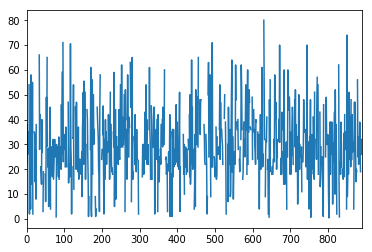

In [112]:
import pandas as pd
titanic_df = titanic.toPandas()
titanic_df['Age'].plot()

In this example, we will restrict ourselves to the following subset of features to train a classifier on: `Pclass`, `Age`, `Sex`. Feel free to extend this list to include all other signals after the class!

## Preprocess data

The `Pclass` and `Age` columns are numeric, but `Sex` is a string categorical variable. We need to convert it to a numeric.

In [113]:
# Compute lists of string categories
def getCategories(df, col):
    vals = sorted(df.select(col).distinct().rdd.map(lambda x: x[0]).collect())
    valDict = dict([(vals[i], i) for i in range(len(vals))])
    print (col + ': ' + ', '.join(vals))
    return (vals, valDict)

(sexes, sexDict) = getCategories(titanic,"Sex")

Sex: female, male


In [114]:
# Convert the string categories into indices
from pyspark.sql.types import *
from pyspark.sql.functions import udf

sexUDF = udf(lambda x: sexDict[x], IntegerType())

titanicIndexed = titanic.select(sexUDF(titanic["Sex"]).alias("Sex"),"Age","Pclass","Survived").cache()

## Handling NAs

For now we will drop a row if there is an NA in any of the columns of the dataframe.

Next we can try imputing the value with mean:
https://stackoverflow.com/questions/40057563/replace-missing-values-with-mean-spark-dataframe

In [115]:
titanicIndexed = titanicIndexed.dropna()
titanicIndexed.show()

+---+----+------+--------+
|Sex| Age|Pclass|Survived|
+---+----+------+--------+
|  1|22.0|     3|       0|
|  0|38.0|     1|       1|
|  0|26.0|     3|       1|
|  0|35.0|     1|       1|
|  1|35.0|     3|       0|
|  1|54.0|     1|       0|
|  1| 2.0|     3|       0|
|  0|27.0|     3|       1|
|  0|14.0|     2|       1|
|  0| 4.0|     3|       1|
|  0|58.0|     1|       1|
|  1|20.0|     3|       0|
|  1|39.0|     3|       0|
|  0|14.0|     3|       0|
|  0|55.0|     2|       1|
|  1| 2.0|     3|       0|
|  0|31.0|     3|       0|
|  1|35.0|     2|       0|
|  1|34.0|     2|       1|
|  0|15.0|     3|       1|
+---+----+------+--------+
only showing top 20 rows



## Train a model

We have preprocessed our data. 

Before feeding to the model, we need to arrange the columns in a specific format. The model Estimator will look for a column named `features` and `label`. Using `VectorAssembler` tool it is very easy to accomplish that task:

In [116]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

featureCols = ["Age", "Sex", "Pclass"]
assembler = VectorAssembler(
    inputCols=featureCols,
    outputCol="features")


titanic = assembler.transform(titanicIndexed).select(col("features"),col("Survived").alias("label"))
titanic.show()

+--------------+-----+
|      features|label|
+--------------+-----+
|[22.0,1.0,3.0]|    0|
|[38.0,0.0,1.0]|    1|
|[26.0,0.0,3.0]|    1|
|[35.0,0.0,1.0]|    1|
|[35.0,1.0,3.0]|    0|
|[54.0,1.0,1.0]|    0|
| [2.0,1.0,3.0]|    0|
|[27.0,0.0,3.0]|    1|
|[14.0,0.0,2.0]|    1|
| [4.0,0.0,3.0]|    1|
|[58.0,0.0,1.0]|    1|
|[20.0,1.0,3.0]|    0|
|[39.0,1.0,3.0]|    0|
|[14.0,0.0,3.0]|    0|
|[55.0,0.0,2.0]|    1|
| [2.0,1.0,3.0]|    0|
|[31.0,0.0,3.0]|    0|
|[35.0,1.0,2.0]|    0|
|[34.0,1.0,2.0]|    1|
|[15.0,0.0,3.0]|    1|
+--------------+-----+
only showing top 20 rows



## Train test split

Here we simply split the labeled dataset into two parts - train and test. Typically, a cross validation fraction is also needed. This might involved stratified sampling of some sort in case of unbalalanced classes.

In [117]:
train, test = titanic.randomSplit([0.8, 0.2])

We now train a Logistic Regression model using `pyspark.ml.classification.LogisticRegression`. 

In [118]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10) #, regParam=0.9, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-0.0272545696251,-3.08204408743,-1.13079838049]
Intercept: 4.402801720128114


In [119]:
preds = lrModel.transform(test) #.select("features", "label", "myProbability", "prediction").collect()

efficiency = preds.filter(preds.label == preds.prediction).count() / float(preds.count())
print ('Train efficiency = ' + str(efficiency))

Train efficiency = 0.7633587786259542


### Example: Pipeline. Hands-on exercise on Adroit

The next example follows the simple text document Pipeline illustrated in the figures above.

Now switch to the Adroit working area and proceed to the Pipelines exercise 